In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob
from matplotlib.gridspec import GridSpec

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters
def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r'\s+', line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r'\s+', line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [4]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine

# where results are stored
results_path = "example_1"
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(results_path, "prof")

# define file name pattern
fn_pref = ["prof_sld(wt%)", "sa", "rate"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")

    # read in data and concatenate
    for file_path in file_paths:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,ab,ka,time,var
180,0.033333,9.999871,0.001065,1.037461,prof_sld(wt%)
181,0.100000,9.999871,0.001067,1.037461,prof_sld(wt%)
182,0.166667,9.999873,0.001066,1.037461,prof_sld(wt%)
183,0.233333,9.999876,0.001064,1.037461,prof_sld(wt%)
184,0.300000,9.999881,0.001061,1.037461,prof_sld(wt%)
...,...,...,...,...,...
957,1.833333,99998.375427,99998.375427,120379.271353,sa
928,1.900000,99999.144429,99999.144429,120379.271353,sa
958,1.900000,99999.144429,99999.144429,120379.271353,sa
929,1.966667,99999.657966,99999.657966,120379.271353,sa


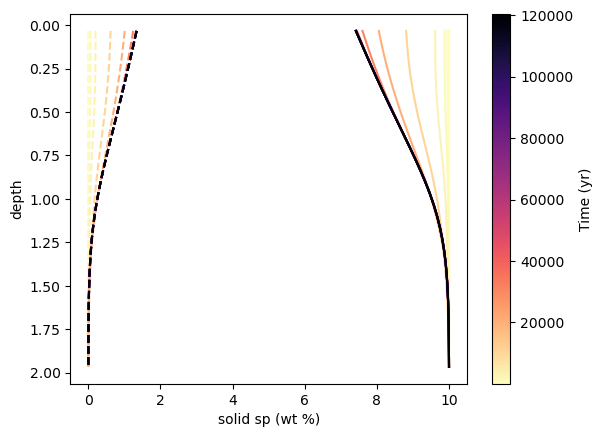

In [5]:
# --- plot depth profile for albite and kaolinite
dfx = df[df['var'] == "prof_sld(wt%)"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby('time')

# Create a colormap
cmap = plt.get_cmap('magma')  # Get the colormap
cmap = cmap.reversed()   # flip colormap
# -- no log normalization
norm = plt.Normalize(df['time'].min(), df['time'].max())  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group['ab'], group['z'], color=color, label=None)
    plt.plot(group['ka'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and a legend
plt.xlabel('solid sp (wt %)')
plt.ylabel('depth')

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label='Time (yr)', ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

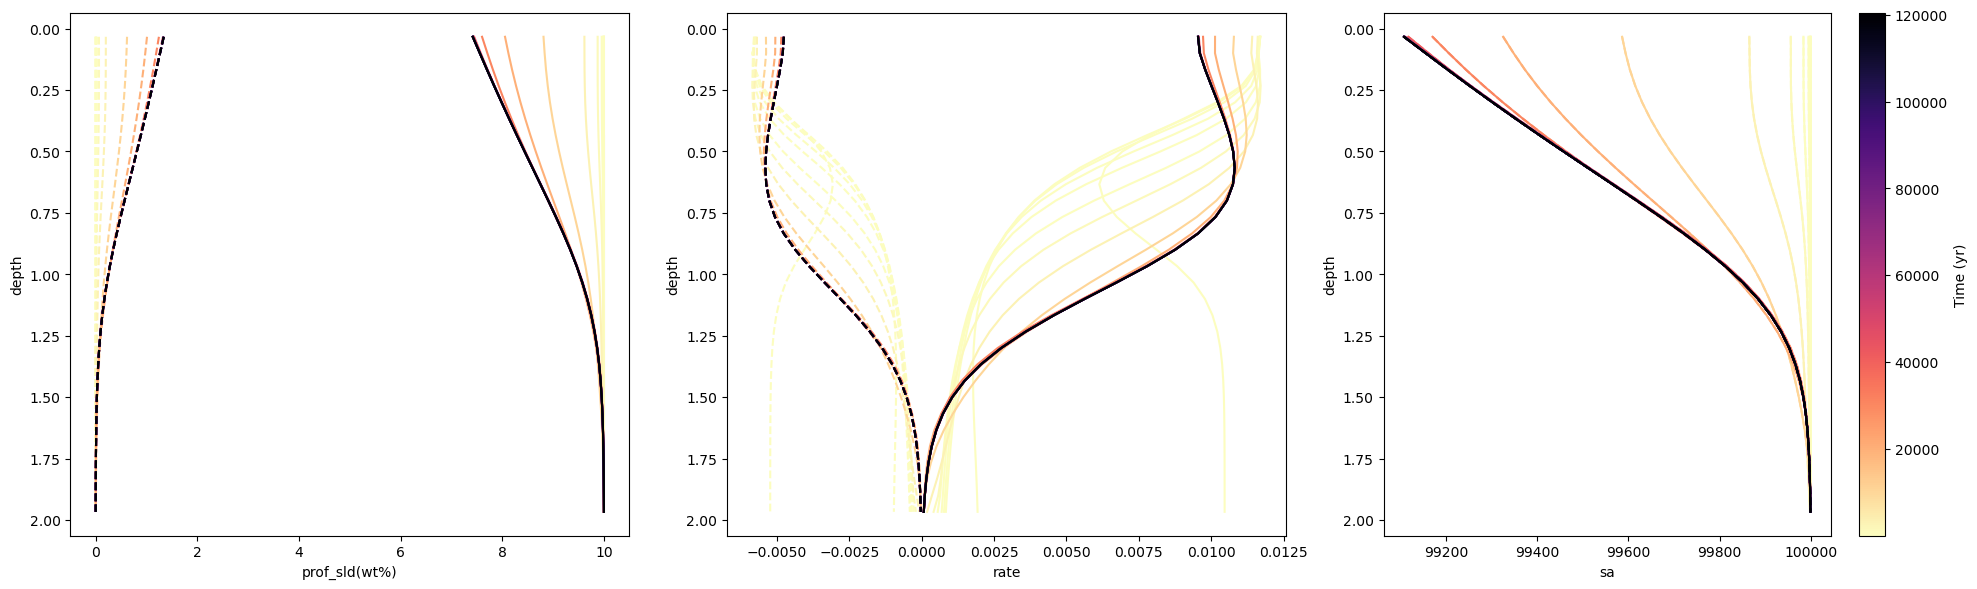

In [6]:
# --- multi-panel plot for all vars
# define number of rows and cols based on unique vars
unique_vars = df['var'].unique()
num_cols = 3 
num_rows = (len(unique_vars) + num_cols - 1) // num_cols

# Create a new figure and set up a GridSpec
fig = plt.figure(figsize=(20, 6))  # Adjust figsize as needed
gs = GridSpec(num_rows, num_cols, figure=fig)

for i, var in enumerate(unique_vars):
    # get the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Create a subplot within the GridSpec
    ax = fig.add_subplot(gs[row, col])
    
    # Filter the DataFrame for the current var
    var_df = df[df['var'] == var]
    
    
    # Group the DataFrame by the 'time' column
    grouped = var_df.groupby('time')

    # Create a colormap
    cmap = plt.get_cmap('magma')  # Get the colormap
    cmap = cmap.reversed()   # flip colormap
    # -- no log normalization
    norm = plt.Normalize(var_df['time'].min(), var_df['time'].max())  # Normalize time values for colormap
    # -- log normalization WIP
    # log_time = np.log(df['time'])
    # norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

    # Create a plot for each time step
    for time, group in grouped:
        color = cmap(norm(time))  # Map time to color using Viridis colormap
        ax.plot(group['ab'], group['z'], color=color, label=None)
        ax.plot(group['ka'], group['z'], color=color, linestyle='dashed', label=None)

    # Add labels and a legend
    ax.set_xlabel(var)
    ax.set_ylabel('depth')

    # Create a colorbar based on the Viridis colormap
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])  # Set an empty array for the colorbar data
    # cbar = plt.colorbar(sm, label='Time (s)', ax=plt.gca())
    
    # Add a legend to the last subplot
    if i == len(unique_vars) - 1:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array for the colorbar data
        cbar = plt.colorbar(sm, label='Time (yr)', ax=plt.gca())

    # flip y-axis
    plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()